In [1]:
# Importing Libraries
import tensorflow as tf
import os
import numpy as np
import sys
import random
import cv2
import glob
import matplotlib.pyplot as plt
import xlrd
import tensorflow.keras.backend as K
import pandas as pd
import requests
# import nvidia_smi

from PIL import Image
from io import BytesIO
from tqdm.notebook import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.python.client import device_lib


# Changing directories to access the dataset
d = os.getcwd()
if d != '/home/ec2-user/SageMaker/Semantic_Segmentation' :
    os.chdir("..")
from labels import *

In [2]:
labelID = {}
rgbColorID = {}

for i,label in enumerate(labels):
    labelID[i] = label.name
    rgbColorID[i] = label.color

print(labelID)
print(rgbColorID)

{0: 'unlabeled', 1: 'dynamic', 2: 'ground', 3: 'road', 4: 'sidewalk', 5: 'parking', 6: 'rail track', 7: 'building', 8: 'wall', 9: 'fence', 10: 'guard rail', 11: 'bridge', 12: 'tunnel', 13: 'pole', 14: 'traffic light', 15: 'traffic sign', 16: 'vegetation', 17: 'terrain', 18: 'sky', 19: 'person', 20: 'rider', 21: 'car', 22: 'truck', 23: 'bus', 24: 'caravan', 25: 'trailer', 26: 'train', 27: 'motorcycle', 28: 'bicycle'}
{0: (0, 0, 0), 1: (111, 74, 0), 2: (81, 0, 81), 3: (128, 64, 128), 4: (244, 35, 232), 5: (250, 170, 160), 6: (230, 150, 140), 7: (70, 70, 70), 8: (102, 102, 156), 9: (190, 153, 153), 10: (180, 165, 180), 11: (150, 100, 100), 12: (150, 120, 90), 13: (153, 153, 153), 14: (250, 170, 30), 15: (220, 220, 0), 16: (107, 142, 35), 17: (152, 251, 152), 18: (70, 130, 180), 19: (220, 20, 60), 20: (255, 0, 0), 21: (0, 0, 142), 22: (0, 0, 70), 23: (0, 60, 100), 24: (0, 0, 90), 25: (0, 0, 110), 26: (0, 80, 100), 27: (0, 0, 230), 28: (119, 11, 32)}


In [3]:
def rgb_to_onehot(rgb_image, colormap):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,)
    encoded_image = np.zeros( shape, dtype=np.int8 )
    index = 0
    for i, cls in enumerate(colormap):
        encoded_image[:,:,index] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
        index += 1
        
    return encoded_image

In [4]:
# Input Image Dimensions
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
numClasses = 29
batchSize = 16
learningRate = 0.001
numOfEpoch = 100

/bin/sh: .gitignore: command not found


In [5]:
def My_Generator(image_filenames, labels, batch_size):
    idx = 0
    batch_x = image_filenames[idx * batch_size:(idx + 1) * batch_size]
    batch_y = labels[idx * batch_size:(idx + 1) * batch_size]

    X_train = []
    Y_train = []

    for i in tqdm(range(len(batch_x))):
        response = requests.get(batch_x[i])
        train = np.asarray(Image.open(BytesIO(response.content)))
        train = cv2.resize(train, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
        X_train.append(train)

    for i in tqdm(range(len(batch_y))):
        response = requests.get(batch_y[i])
        img1 = np.asarray(Image.open(BytesIO(response.content)).convert('RGB'))
#             imgCopy = np.zeros(img1.shape, dtype = 'uint8')
#             for i,cls in enumerate(rgbColorID):
#                 if i in otherClassIndices:
#                     imgCopy[np.all(img1.reshape((-1,3)) == rgbColorID[i],axis=1).reshape(img1.shape[:2])] = rgbColorID[0]
#                 else:
#                     imgCopy[np.all(img1.reshape((-1,3)) == rgbColorID[i],axis=1).reshape(img1.shape[:2])] = rgbColorID[i]
        Mask = cv2.resize(img1, (IMG_WIDTH,IMG_HEIGHT), interpolation = cv2.INTER_AREA)
#         Mask = rgb_to_onehot(Mask, rgbColorID)
        Y_train.append(Mask)

    np.savez_compressed('Val29', image = np.array(X_train, dtype='uint8'),
                                   label = np.array(Y_train, dtype='uint8'))
    
    return 100

In [6]:
parameter = False
if parameter:
    temp = My_Generator(validationImagesNames, validationMasksNames,len(validationImagesNames))

In [7]:
# Building the U-net model
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)) # Defining the input layer
s = tf.keras.layers.Lambda(lambda x: x/255)(inputs) # Converting input pixels to floating values

c1 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
# c1 = tf.keras.layers.Dropout(0.1)(c1) # To prevent neural net from over fitting
c1 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)


c2 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
# c2 = tf.keras.layers.Dropout(0.1)(c2) # To prevent neural net from over fitting
c2 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)


c3 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
# c3 = tf.keras.layers.Dropout(0.2)(c3) # To prevent neural net from over fitting
c3 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
# c4 = tf.keras.layers.Dropout(0.2)(c4) # To prevent neural net from over fitting
c4 = tf.keras.layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
# c5 = tf.keras.layers.Dropout(0.3)(c5) # To prevent neural net from over fitting
c5 = tf.keras.layers.Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
# p5 = tf.keras.layers.MaxPooling2D((2,2))(c5)

# c6 = tf.keras.layers.Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='valid')(p5)
# c6 = tf.keras.layers.Dropout(0.3)(c6) # To prevent neural net from over fitting
# # c6 = tf.keras.layers.Conv2D(1024, (3,3), activation='relu', kernel_initializer='he_normal', padding='valid')(c6)
# # p6 = tf.keras.layers.MaxPooling2D((2,2))(c6)

# Decoding the layers
u7 = tf.keras.layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding='same')(c5)
# h, w = u7.shape[1:3].as_list()
# cr5 = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, size=[h,w],method='bilinear'))(c4)
u7 = tf.keras.layers.concatenate([u7, c4])
c7 = tf.keras.layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
# c7 = tf.keras.layers.Dropout(0.2)(c7) # To prevent neural net from over fitting
c7 = tf.keras.layers.Conv2D(512, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
# c7 = tf.keras.layers.Dropout(0.2)(c7)

u8 = tf.keras.layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c7)
# h, w = u8.shape[1:3].as_list()
# cr4 = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, size=[h,w],method='bilinear'))(c3)
u8 = tf.keras.layers.concatenate([u8, c3])
c8 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
# c8 = tf.keras.layers.Dropout(0.2)(c8) # To prevent neural net from over fitting
c8 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
# c8 = tf.keras.layers.Dropout(0.2)(c8)

u9 = tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c8)
# h, w = u9.shape[1:3].as_list()
# cr3 = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, size=[h,w],method='bilinear'))(c2)
u9 = tf.keras.layers.concatenate([u9, c2])
c9 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
# c9 = tf.keras.layers.Dropout(0.1)(c9) # To prevent neural net from over fitting
c9 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
# c9 = tf.keras.layers.Dropout(0.1)(c9)

u10 = tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c9)
# h, w = u10.shape[1:3].as_list()
# cr2 = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, size=[h,w],method='bilinear'))(c1)
u10 = tf.keras.layers.concatenate([u10, c1], axis=3)
c10 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
# c10 = tf.keras.layers.Dropout(0.1)(c10) # To prevent neural net from over fitting
c10 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
# c10 = tf.keras.layers.Dropout(0.1)(c10)

outputs = tf.keras.layers.Conv2D(numClasses, (1,1), activation='sigmoid', padding='same')(c10)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=numClasses),
                                                                          tf.keras.metrics.Precision(),
                                                                          tf.keras.metrics.Recall(),
                                                                          'accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
______________________________________________________________________________________________

In [8]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_multiclass.h5',
                                                  verbose=2,
                                                  save_best_only=True,
                                                  monitor='loss',
                                                  mode='min')

callbacks = [
             tf.keras.callbacks.EarlyStopping(patience=1,
                                              monitor='loss',
                                              mode='min'),
             tf.keras.callbacks.TensorBoard(log_dir='logs',
                                            write_graph=True)]

In [9]:
response = requests.get('https://test-seg.s3.amazonaws.com/Cityscrapes/Train29.npz')
train = np.load(BytesIO(response.content))

In [10]:
results = model.fit(train['image'], train['label'], validation_split=0.3, batch_size = batchSize,callbacks=callbacks, verbose = 1,epochs = numOfEpoch)

Train on 2082 samples, validate on 893 samples
Epoch 1/100
2082/2082 [==============================] - 273s 131ms/sample - loss: 2.1536 - mean_io_u: 0.4932 - precision: 0.1253 - recall: 0.8596 - accuracy: 0.1579 - val_loss: 1.8982 - val_mean_io_u: 0.5018 - val_precision: 0.1807 - val_recall: 0.8489 - val_accuracy: 0.1571
Epoch 2/100
2082/2082 [==============================] - 250s 120ms/sample - loss: 1.7056 - mean_io_u: 0.5015 - precision: 0.2139 - recall: 0.8517 - accuracy: 0.1999 - val_loss: 1.6672 - val_mean_io_u: 0.4898 - val_precision: 0.2467 - val_recall: 0.8319 - val_accuracy: 0.2466
Epoch 3/100
2082/2082 [==============================] - 251s 121ms/sample - loss: 1.3278 - mean_io_u: 0.4908 - precision: 0.3046 - recall: 0.8560 - accuracy: 0.2934 - val_loss: 0.9783 - val_mean_io_u: 0.4838 - val_precision: 0.6221 - val_recall: 0.7034 - val_accuracy: 0.6237


In [ ]:
train = []

In [13]:
model.save('models/unet-S256-C29-B16')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: U-net/unet-S256-C29-B16/assets


In [12]:
response = requests.get('https://test-seg.s3.amazonaws.com/Cityscrapes/Val29.npz')
test = np.load(BytesIO(response.content))
X_test = test['image']
Y_test = test['label']

In [10]:
model = tf.keras.models.load_model('models/unet-S256-C29-B16')

In [13]:
preds_val = model.predict(X_test, verbose=1)

500/500 [==============================] - 34s 68ms/sample


In [14]:
def onehot_to_rgb(onehot, colormap):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

In [15]:
preds_valRGB = []
for i in range(len(X_test)):
    preds_valRGB.append(onehot_to_rgb(preds_val[i], rgbColorID))

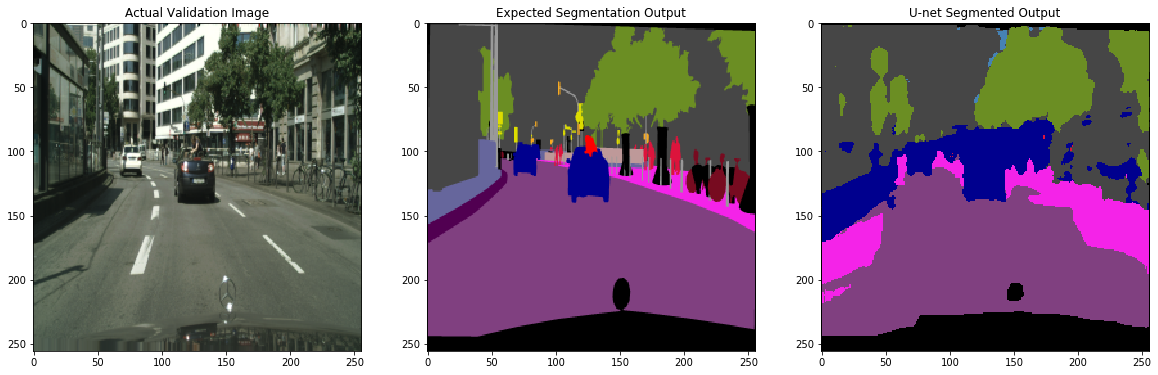

In [20]:
# Comparing the results

ix = random.randint(0, len(preds_valRGB))
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(X_test[ix])
ax1.title.set_text('Actual Validation Image')
ax1.grid(False)
ax2 = fig.add_subplot(1,3,2)
ax2.set_title('Expected Segmentation Output')
ax2.imshow(Y_test[ix])
ax2.grid(False)
ax3 = fig.add_subplot(1,3,3)
ax3.set_title('U-net Segmented Output')
ax3.imshow(preds_valRGB[ix])
ax3.grid(False)

In [21]:
iou = []
classesPresent = ['Absent']*numClasses
s = np.zeros(numClasses)
for j in tqdm(range(len(X_test))):
    temp = rgb_to_onehot(Y_test[j], rgbColorID)
    for i in range(numClasses):
        if 1 in temp[:,:,i]:
            classesPresent[i] = 'Present'
        intersection = np.logical_and(temp[:,:,i], preds_val[j][:,:,i])
        union = np.logical_or(temp[:,:,i], preds_val[j][:,:,i])
        s[i] += np.sum(intersection) / np.sum(union)
        
s = s/len(X_test)
for i in range(numClasses):
    iou.append(str(round(s[i]*100, 3)) + '%')

labels = []
for i in range(numClasses):
    labels.append(labelID[i])
    
classes = {'labels': labels,
        'IOU Accuracy': iou,
        'Classes Encountered' : classesPresent
        }

df = pd.DataFrame(classes, columns = ['labels','IOU Accuracy', 'Classes Encountered'])

print (df)


           labels IOU Accuracy Classes Encountered
0       unlabeled       8.681%             Present
1         dynamic       0.356%             Present
2          ground       1.712%             Present
3            road      32.345%             Present
4        sidewalk       4.331%             Present
5         parking       0.359%             Present
6      rail track       0.058%             Present
7        building      17.985%             Present
8            wall       0.584%             Present
9           fence       0.653%             Present
10     guard rail       0.003%             Present
11         bridge       0.025%             Present
12         tunnel         0.0%              Absent
13           pole       0.592%             Present
14  traffic light        0.12%             Present
15   traffic sign       0.459%             Present
16     vegetation      14.096%             Present
17        terrain       0.656%             Present
18            sky       2.699%

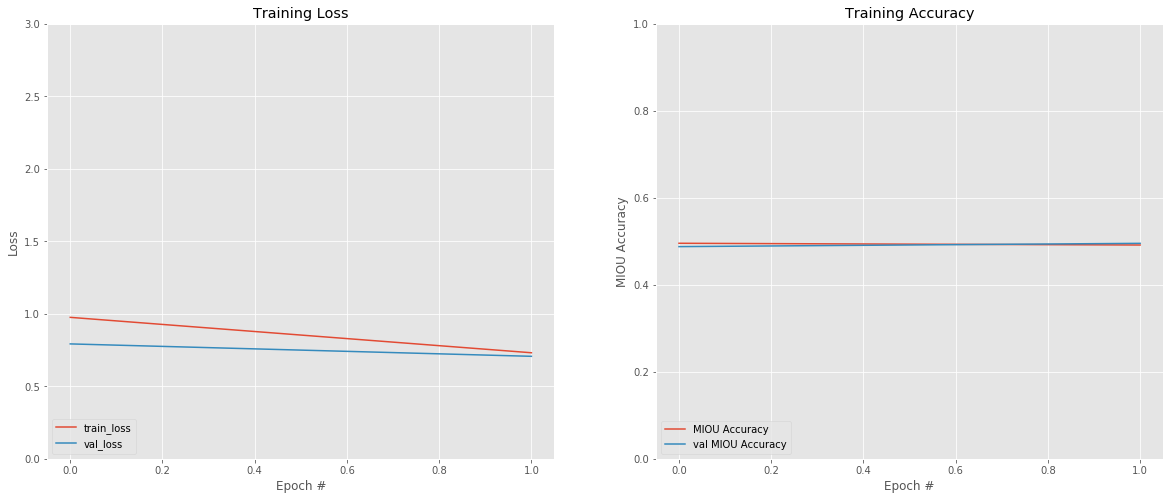

In [24]:
N = len(results.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), results.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), results.history["val_loss"], label="val_loss")
plt.ylim(0, 3)

plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

fig.add_subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), results.history["mean_io_u"], label="MIOU Accuracy")
plt.plot(np.arange(0, N), results.history["val_mean_io_u"], label="val MIOU Accuracy")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("MIOU Accuracy")
plt.legend(loc="lower left")
plt.show()

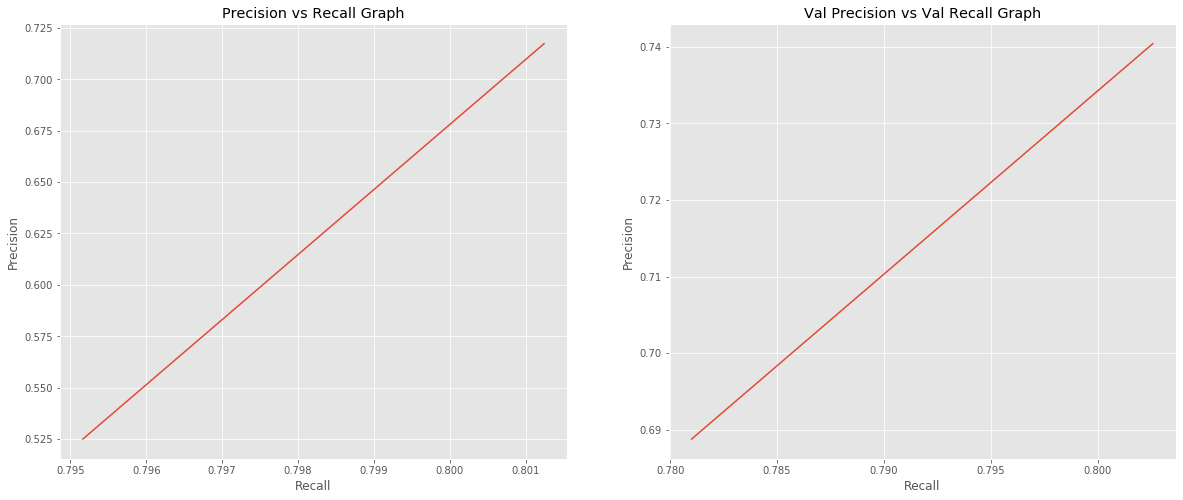

In [28]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.plot(results.history['recall'], results.history['precision']) 
# naming the x axis 
plt.xlabel('Recall') 
# naming the y axis 
plt.ylabel('Precision') 
  
# giving a title to my graph 
plt.title('Precision vs Recall Graph') 
  
    
fig.add_subplot(1,2,2)
plt.plot(results.history['val_recall'], results.history['val_precision']) 
# naming the x axis 
plt.xlabel('Recall') 
# naming the y axis 
plt.ylabel('Precision') 
  
# giving a title to my graph 
plt.title('Val Precision vs Val Recall Graph') 
    
# function to show the plot 
plt.show() 